# Gradient-based CCA and Adaptive CCA

This script demonstrates how to use gradient-based methods to perform canonical correlation analysis (CCA) on high-dimensional data. We will apply CCA and GCCA on a toy set and illustrate the path chosen for optimization problem on a Stiefel manifold.

In [30]:
# Ana Carsi 
# CCA with Stiefel manifold optimization
# scripts/run_cca.ipynb

import numpy as np
from sklearn.cross_decomposition import CCA

# Generate some random data
np.random.seed(42)
X = np.random.rand(100, 10)  # 100 samples, 10 features
Y = np.random.rand(100, 10)  # 100 samples, 10 features

# Initialize the CCA model
n_components = 2  # Number of components to extract
cca = CCA(n_components=n_components)

# Fit the model to the data
cca.fit(X, Y)

# Transform the data
X_c, Y_c = cca.transform(X, Y)

# Print the transformed data
print("Transformed X shape:", X_c.shape)
print("Transformed Y shape:", Y_c.shape)

print("Canonical correlations:", np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_components))

Transformed X shape: (100, 2)
Transformed Y shape: (100, 2)
Canonical correlations: [0.49956658 0.44971895]


In [31]:
# Repetition with cca_zoo functionality
import numpy as np
import matplotlib.pyplot as plt
from cca_zoo.linear import CCA

# Generate synthetic data
np.random.seed(42)  # for reproducibility

n_samples = 100
n_features_x = 10
n_features_y = 8
n_components = 2

# Generate random data for X and Y
X = np.random.randn(n_samples, n_features_x)
Y = np.random.randn(n_samples, n_features_y)

# Add some correlation between X and Y
for i in range(min(n_features_x, n_features_y)): # loop over the minimum number of features
    X[:, i] += Y[:, i]

# Perform CCA
cca = CCA(latent_dimensions=n_components)
cca.fit((X, Y)) # pass data as a tuple

# Transform data
X_scores, Y_scores = cca.transform((X, Y))

# Print transformed shapes and canonical correlations
print("Transformed X shape:", X_scores.shape)
print("Transformed Y shape:", Y_scores.shape)


Transformed X shape: (100, 2)
Transformed Y shape: (100, 2)


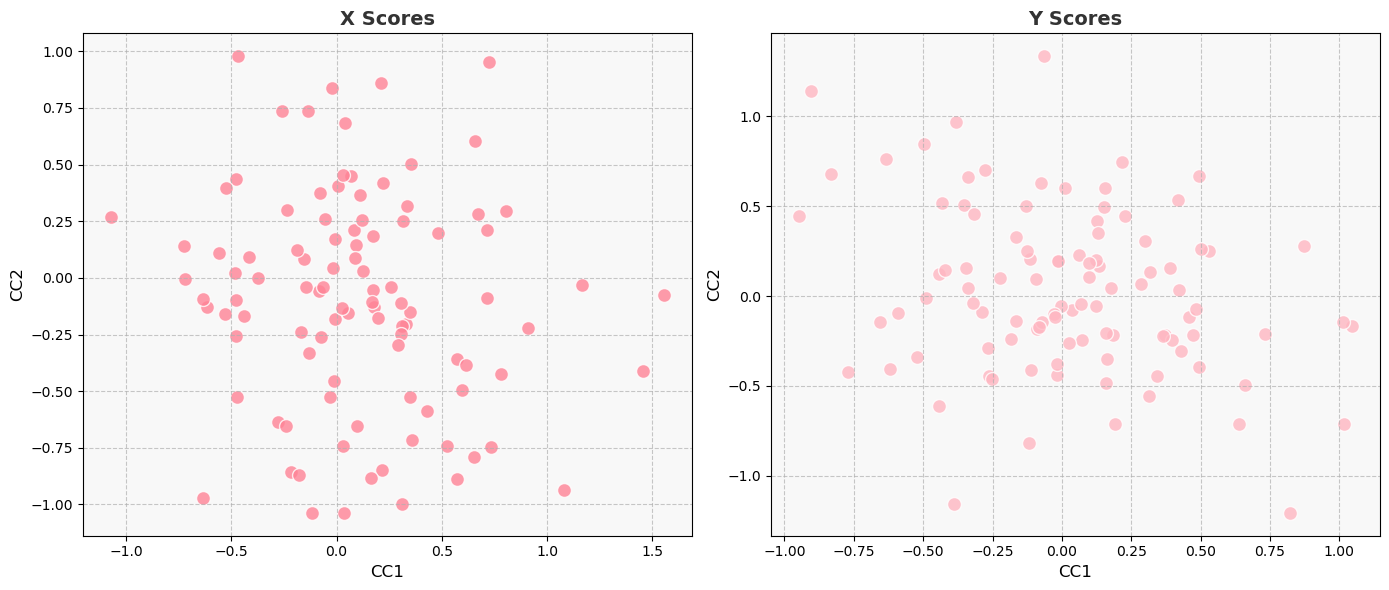

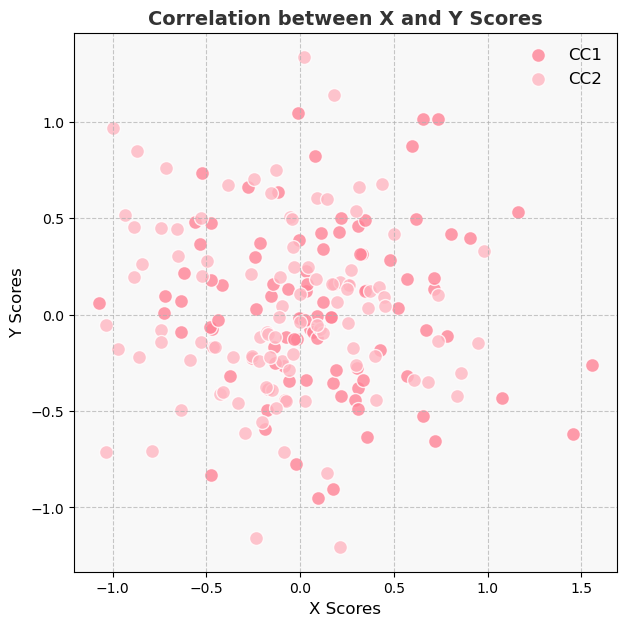

In [54]:
plt.figure(figsize=(14, 6), facecolor='white')
# Plot X scores
plt.subplot(121)
plt.scatter(X_scores[:, 0], X_scores[:, 1], color='#FF8396', alpha=0.8, edgecolor='white', s=100)  # Dark Pink
plt.title('X Scores', fontsize=14, fontweight='bold', color='#333333')
plt.xlabel('CC1', fontsize=12)
plt.ylabel('CC2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#F8F8F8')

# Plot Y scores
plt.subplot(122)
plt.scatter(Y_scores[:, 0], Y_scores[:, 1], color='#FFB6C1', alpha=0.8, edgecolor='white', s=100)  # Light Pink
plt.title('Y Scores', fontsize=14, fontweight='bold', color='#333333')
plt.xlabel('CC1', fontsize=12)
plt.ylabel('CC2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#F8F8F8')

plt.tight_layout()
plt.show()


# Plot correlation between X and Y scores
plt.figure(figsize=(7, 7), facecolor='white')
plt.scatter(X_scores[:, 0], Y_scores[:, 0], color='#FF8396', label='CC1', alpha=0.8, edgecolor='white', s=100)  # Dark Pink
plt.scatter(X_scores[:, 1], Y_scores[:, 1], color='#FFB6C1', label='CC2', alpha=0.8, edgecolor='white', s=100)  # Light Pink
plt.title('Correlation between X and Y Scores', fontsize=14, fontweight='bold', color='#333333')
plt.xlabel('X Scores', fontsize=12)
plt.ylabel('Y Scores', fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#F8F8F8')
plt.show()

# Adaptive CCA

Implementation of adaptive CCA using the Brockett function.

In [43]:
from scipy.linalg import eigh

class AdaptiveCCA:
    def __init__(self, n_components, n_features_x, n_features_y, forgetting_factor=0.9, regularization=1e-4):
        self.n_components = n_components
        self.forgetting_factor = forgetting_factor
        self.regularization = regularization
        
        # Initialize the covariance matrices. A small value will be added to the diagonal for numerical stability
        self.C1 = np.eye(n_features_x) 
        self.C2 = np.eye(n_features_y) 
        self.C12 = np.zeros((n_features_x, n_features_y))

        # Initialize the transformation matrices
        self.U = np.eye(n_features_x, n_components)
        self.V = np.eye(n_features_y, n_components)
        
    def update_covariances(self, x_t, y_t):
        # Update covariance matrices with the forgetting factor
        self.C1 = self.forgetting_factor * self.C1 + np.outer(x_t, x_t) 
        self.C2 = self.forgetting_factor * self.C2 + np.outer(y_t, y_t)
        self.C12 = self.forgetting_factor * self.C12 + np.outer(x_t, y_t)

        # Regularize to ensure positive definiteness
        self.C1 += self.regularization * np.eye(self.C1.shape[0])
        self.C2 += self.regularization * np.eye(self.C2.shape[0])
        
    def optimize_brockett_function(self):
        # Compute the matrices A and N
        A = self.C12
        N = np.diag(np.linspace(0.1, 1.0, A.shape[0]))  # N with arbitrary decreasing values
        
        # Adjust N to match the size of A.T
        N_x = np.diag(np.linspace(0.1, 1.0, A.shape[0]))  # N_x with arbitrary decreasing values
        N_y = np.diag(np.linspace(0.1, 1.0, A.shape[1]))  # N_y with arbitrary decreasing values
        
        # Solve the generalized eigenvalue problem for U
        M = A @ N_y @ A.T
        eigvals, eigvecs = eigh(M, self.C1)
        self.U = eigvecs[:, :self.n_components]

        # Solve the generalized eigenvalue problem for V
        M = A.T @ N_x @ A
        eigvals, eigvecs = eigh(M, self.C2)
        self.V = eigvecs[:, :self.n_components]

    def fit_transform(self, X, Y):
        for x_t, y_t in zip(X, Y):
            # Update covariance matrices with new data
            self.update_covariances(x_t, y_t)
            
            # Optimize the Brockett function to update U and V
            self.optimize_brockett_function()
        
        # Transform the data
        X_scores = X @ self.U
        Y_scores = Y @ self.V
        
        return X_scores, Y_scores


In [44]:
n_samples = 100
n_features_x = 10
n_features_y = 8
n_components = 2

X = np.random.randn(n_samples, n_features_x)
Y = np.random.randn(n_samples, n_features_y)

adaptive_cca = AdaptiveCCA(n_components=n_components, n_features_x=n_features_x, n_features_y=n_features_y)

# Fit and transform the data
X_scores, Y_scores = adaptive_cca.fit_transform(X, Y)

print("X Scores:", X_scores[:5])
print("Y Scores:", Y_scores[:5])

X Scores: [[-0.01256714 -0.45399959]
 [-0.63327924 -0.97071154]
 [-0.61828905 -0.12645329]
 [-0.21646885 -0.85691976]
 [ 0.57144838 -0.35653   ]]
Y Scores: [[ 1.04694722 -0.16765494]
 [-0.08864702 -0.18003427]
 [ 0.21530073  0.74928237]
 [ 0.37314878 -0.2177273 ]
 [ 0.18580135 -0.2185069 ]]


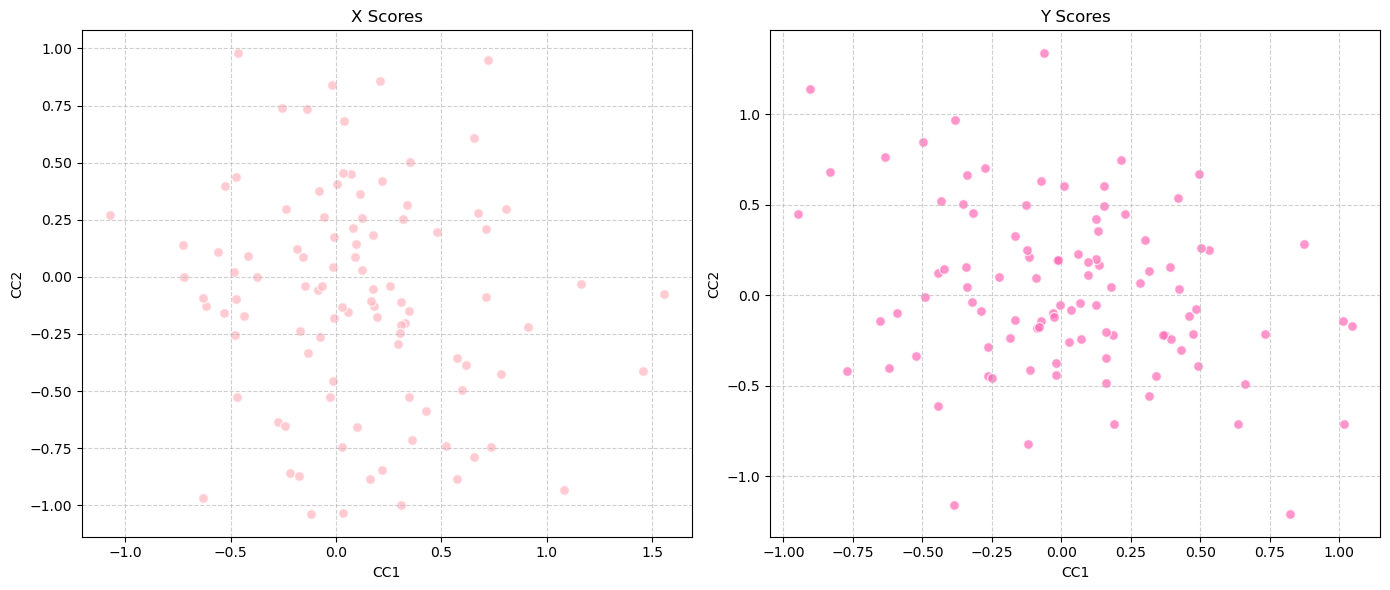

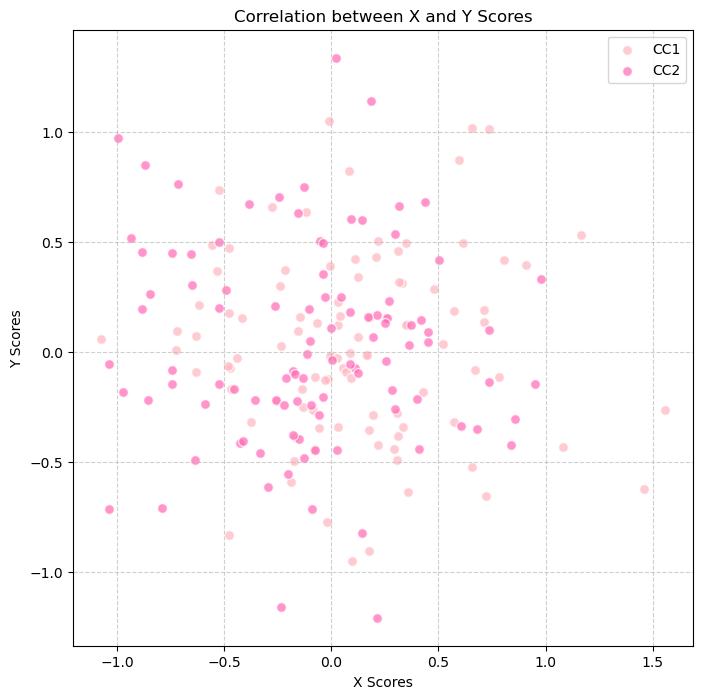

In [59]:
def plot_results(X_scores, Y_scores):
    plt.figure(figsize=(14, 6))
    # Plot X scores
    plt.subplot(1, 2, 1)
    plt.scatter(X_scores[:, 0], X_scores[:, 1], c='lightpink', s=50, alpha=0.7, edgecolors='white')
    plt.title('X Scores')
    plt.xlabel('CC1')
    plt.ylabel('CC2')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Y scores
    plt.subplot(1, 2, 2)
    plt.scatter(Y_scores[:, 0], Y_scores[:, 1], c='hotpink', s=50, alpha=0.7, edgecolors='white')
    plt.title('Y Scores')
    plt.xlabel('CC1')
    plt.ylabel('CC2')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Plot correlation between X and Y scores
    plt.figure(figsize=(8, 8))
    plt.scatter(X_scores[:, 0], Y_scores[:, 0], c='lightpink', s=50, alpha=0.7, edgecolors='white', label='CC1')
    plt.scatter(X_scores[:, 1], Y_scores[:, 1], c='hotpink', s=50, alpha=0.7, edgecolors='white', label='CC2')
    plt.title('Correlation between X and Y Scores')
    plt.xlabel('X Scores')
    plt.ylabel('Y Scores')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_results(X_scores, Y_scores)
